In [138]:
import polars as pl
import seaborn as sns
import json
import re
import string
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_theme()

In [139]:
nbse_df = pl.read_parquet(
    "/projectnb/vkolagrp/bellitti/clinicalnotes-databasing-validated/results/NBSE_tabulated.parquet"
)

parsed_syndromes = (
    nbse_df.select("VAC", "diagnosis", pl.col("clinical_syndrome").str.to_lowercase())
    .filter(pl.col("VAC") > 100)
    .fill_null("null")
)

parsed_syndromes

# parsed_syndromes_list = parsed_syndromes['clinical_syndrome'].to_list()


VAC,diagnosis,clinical_syndrome
i64,str,str
1393,"""Mild Dementia""","""progressive amnestic dysfuncti…"
759,"""Mild Dementia""","""mild dementia"""
2120,"""Mild Dementia""","""progressive amnestic dysfuncti…"
1769,"""Mild Cognitive Impairment (MCI…","""non-amnestic, dysexecutive/fro…"
2122,"""Moderate Dementia""","""multi-domain dysfunction with …"
…,…,…
1218,"""Subjective Cognitive Decline (…","""null"""
1065,"""Mild Cognitive Impairment (MCI…","""amnestic mci"""
460,"""Very Mild Dementia""","""alzheimer's disease"""


In [192]:
nlp = spacy.load("en_core_web_lg")  # for lemmatization

with open("../data/specific_syndromes_reference.json") as f:
    syndrome_ref = json.load(f)

with open("../data/clinical_diagnoses.json") as f:
    diagnosis_ref = json.load(f)

In [224]:
def clean(text):
    # clean and lemmatize text
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    text = re.sub(r"\s+", " ", text).strip()
    doc = nlp(text)
    # return " ".join([token.lemma_ for token in doc if not token.is_stop])
    return " ".join([token.lemma_ for token in doc]) 


def jaccard(vec1, vec2):
    # compute jaccard index between two sparse tf-idf vectors, ignoring weights
    set1 = set(vec1.nonzero()[1])
    set2 = set(vec2.nonzero()[1])
    inter = len(set1 & set2)
    union = len(set1 | set2)
    return inter / union if union else 0


def weighted_jaccard(v1, v2):
    # compute weighted jaccard index between two sparse tf-idf vectors
    v1, v2 = v1.toarray().flatten(), v2.toarray().flatten()
    min_sum = np.minimum(v1, v2).sum()
    max_sum = np.maximum(v1, v2).sum()
    return min_sum / max_sum if max_sum else 0.0

Figure out way to include VAC

In [232]:
def match_to_reference(sentences, references, max_ngram=2):
    # candidates is a list of strings that you want to match to the best fitting reference
    # references is a dictionary, the keys are reference sentences (synonyms), and values are codes that uniquely identify that reference

    ref_texts = list(references.keys())

    ref_clean = [clean(r) for r in ref_texts]
    sent_clean = [clean(s) for s in sentences]

    vectorizer = TfidfVectorizer(
        ngram_range=(1, max_ngram)
    )  # unigrams and bigrams, so it's not just bag-of-words
    tfidf = vectorizer.fit_transform(ref_clean + sent_clean)
    ref_vecs = tfidf[: len(ref_clean)]
    sent_vecs = tfidf[len(ref_clean) :]

    # Match by weighted Jaccard
    matches = []

    for i in tqdm(range(len(sentences))):
        s = sent_clean[i]
        v = sent_vecs[i]
        match_dict = {}

        sims = [weighted_jaccard(v, r) for r in ref_vecs]
        best_idx = np.argmax(sims)

        match_dict["sent_clean"] = s
        match_dict["sentence"] = sentences[i]
        match_dict["J"] = sims[best_idx]
        match_dict["best_match"] = ref_texts[best_idx]
        match_dict["code"] = references[ref_texts[best_idx]]  # abbreviation

        matches.append(match_dict)

    return pl.DataFrame(matches)

In [226]:
match_df = match_to_reference(
    parsed_syndromes["clinical_syndrome"].to_list(), syndrome_ref,max_ngram=2
)

100%|██████████| 1859/1859 [00:03<00:00, 494.00it/s]


In [227]:
syndrome_df = pl.concat((parsed_syndromes.select("VAC"), match_df), how="horizontal")

remove_from_syndrome = [
    "amnestic mci",
    "amnesic mci",
    "mild dementia",
    "mild cognitive impairment",
    "amnestic mild cognitive impairment",
    "non amnestic mild cognitive impairment",
    "non amnestic mci",
    "subjective cognitive decline",
    "mci amnestic subtype",
    "dementia",
]


# set to null cases where the syndrome was not identified at all
syndrome_df = syndrome_df.with_columns(
    pl.when(pl.col("sent_clean").is_in(remove_from_syndrome)).then(None).otherwise(pl.col("code")).alias('code')
)

# set to null cases where the syndrome does not match enough one of the references
syndrome_df = syndrome_df.with_columns(
    pl.when(pl.col("J") < 0.1).then(None).otherwise(pl.col("code")).alias("code")
)

In [228]:
syndrome_df

VAC,sent_clean,J,best_match,code
i64,str,f64,str,str
1393,"""progressive amnestic dysfuncti…",1.0,"""progressive amnestic dysfuncti…","""PAD"""
759,"""mild dementia""",0.147185,"""vascular dementia""",null
2120,"""progressive amnestic dysfuncti…",0.255755,"""executive dysfunction""","""FED"""
1769,"""non amnestic dysexecutive fron…",0.517476,"""dysexecutive frontal pattern""","""FED"""
2122,"""multi domain dysfunction with …",0.132829,"""multi-domain amnestic mci""","""GMCI"""
…,…,…,…,…
1218,"""null""",1.0,"""null""",null
1065,"""amnestic mci""",0.187663,"""multi-domain amnestic mci""",null
460,"""alzheimer s disease""",1.0,"""alzheimer's disease""","""AD"""


In [233]:
match_df = match_to_reference(parsed_syndromes["diagnosis"].to_list(), diagnosis_ref,max_ngram=3)

100%|██████████| 1859/1859 [00:00<00:00, 2331.81it/s]


In [234]:
diagnosis_df = pl.concat((parsed_syndromes.select("VAC"), match_df), how="horizontal")

remove_from_diagnosis = [
    "amnestic mci",
    "amnesic mci",
    "mild dementia",
    "mild cognitive impairment",
    "amnestic mild cognitive impairment",
    "non amnestic mild cognitive impairment",
    "non amnestic mci",
    "subjective cognitive decline",
    "mci amnestic subtype",
    "dementia",
]


# set to null cases where the syndrome was not identified at all
# syndrome_df = syndrome_df.with_columns(
    # pl.when(pl.col("sent_clean").is_in(remove_from_syndrome)).then(None).otherwise(pl.col("code")).alias('code_no_diag')
# )

# set to null cases where the syndrome does not match enough one of the references
diagnosis_df = diagnosis_df.with_columns(
    pl.when(pl.col("J") < 0.1).then(None).otherwise(pl.col("code")).alias("code")
)

In [329]:
diagnosis_df.filter(pl.col('code') == 'NC')
# diagnosis_df.filter(pl.col('VAC') == 555)
# diagnosis_df.filter(pl.col('sentence').str.contains('to'))

VAC,sent_clean,sentence,J,best_match,code
i64,str,str,f64,str,str
469,"""normal cognition""","""Normal Cognition""",1.0,"""normal cognition""","""NC"""
785,"""normal cognition""","""Normal Cognition""",1.0,"""normal cognition""","""NC"""
1125,"""normal cognition""","""Normal Cognition""",1.0,"""normal cognition""","""NC"""
659,"""normal cognition""","""Normal Cognition""",1.0,"""normal cognition""","""NC"""
595,"""normal cognition""","""Normal Cognition""",1.0,"""normal cognition""","""NC"""
…,…,…,…,…,…
2216,"""normal cognition""","""Normal Cognition""",1.0,"""normal cognition""","""NC"""
923,"""normal cognition""","""Normal Cognition""",1.0,"""normal cognition""","""NC"""
819,"""normal cognition""","""Normal Cognition""",1.0,"""normal cognition""","""NC"""


In [265]:
diagnosis_df.filter(pl.col('code').is_null())

VAC,sent_clean,sentence,J,best_match,code
i64,str,str,f64,str,str
2169,"""null""","""null""",1.0,"""null""",null
1857,"""null""","""null""",1.0,"""null""",null
667,"""primary progressive aphasia se…","""Primary Progressive Aphasia, S…",0.0,"""null""",null
1033,"""behavioral variant frontotempo…","""Behavioral variant frontotempo…",0.016324,"""dementia""",null
1892,"""null""","""null""",1.0,"""null""",null
2170,"""null""","""null""",1.0,"""null""",null


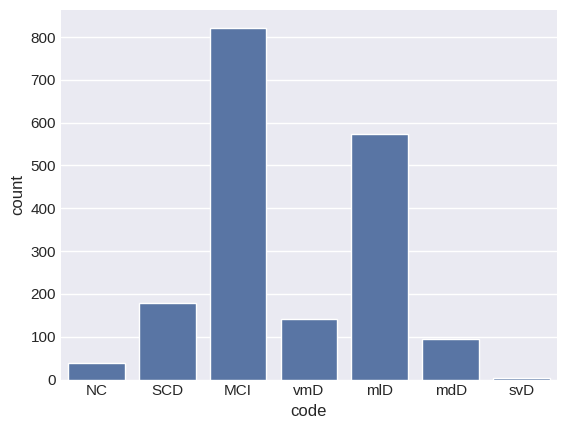

In [315]:
diagnosis_order = ["NC", "SCD", "MCI", "vmD", "mlD", "mdD", "svD"]

g = sns.countplot(diagnosis_df, x="code",order=diagnosis_order)

plt.savefig('../figures/diagnosis_distrib.png')

In [320]:
from datetime import date

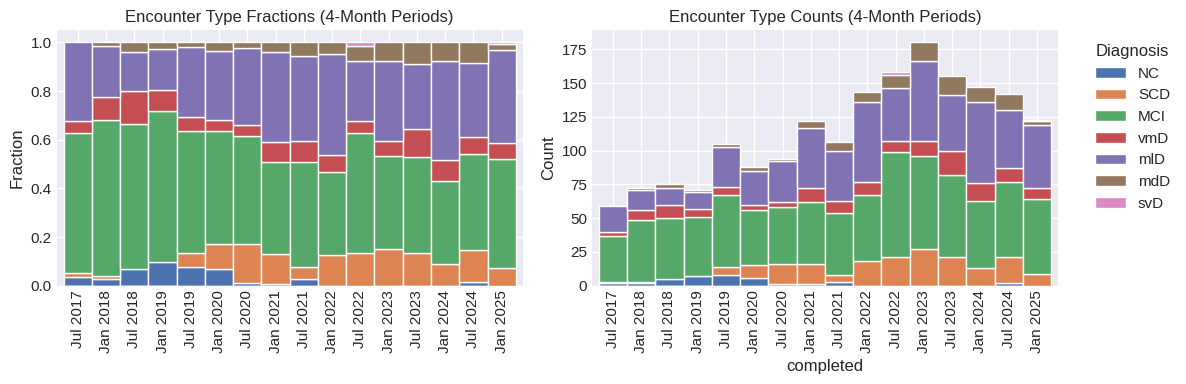

In [347]:
counts = (
    nbse_df.join(diagnosis_df, on="VAC")
    .filter(pl.col('completed') >= date(2017,7,1))
    .filter(pl.col('completed') <= date(2025,6,30))
    .drop_nulls("completed")
    .drop_nulls("code")
    .with_columns(pl.col("completed").dt.round("6mo"))
    .group_by("completed", "code")
    .agg(pl.col("code").count().alias("count")).with_columns(
        (pl.col('count') / pl.col('count').sum().over('completed')).alias('fraction')
    ).sort('completed','code')
    .to_pandas()
)

# Bin by quarter
plt.style.use("seaborn-v0_8-darkgrid")

# Fractions
# counts["fraction"] = counts.groupby("completed")["count"].transform(
    # lambda x: x / x.sum()
# )

# Pivot for stacked bar plotting
fractions = counts.pivot(index="completed", columns="code", values="fraction").fillna(0)
counts_pivot = counts.pivot(index="completed", columns="code", values="count").fillna(0)

# Reorder columns
fractions = fractions[diagnosis_order]
counts_pivot = counts_pivot[diagnosis_order]

# Two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# Fractions plot
fractions.plot(kind="bar", stacked=True, ax=axes[0], width=1.0)
axes[0].set_ylabel("Fraction")
axes[0].set_title("Encounter Type Fractions (4-Month Periods)")
axes[0].set_xticklabels(
    [d.strftime("%b %Y") for d in fractions.index], rotation=90, ha="center"
)
axes[0].legend_.remove()

axes[0].set_xlabel('')
axes[1].set_xlabel('')

# Counts plot
counts_pivot.plot(kind="bar", stacked=True, ax=axes[1], width=1.0)
axes[1].set_ylabel("Count")
axes[1].set_title("Encounter Type Counts (4-Month Periods)")
axes[1].set_xticklabels(
    [d.strftime("%b %Y") for d in counts_pivot.index], rotation=90, ha="center"
)

# Legend outside
axes[1].legend(title="Diagnosis", bbox_to_anchor=(1.05, 1), loc="upper left")

fig.tight_layout()

fig.savefig('../figures/diagnosis_frac_over_time.png')

In [277]:
diagnosis_df.select(
    pl.col('code').value_counts(normalize=False)
).unnest('code').sort('code')

code,count
str,u32
null,6
"""MCI""",822
"""NC""",38
"""SCD""",180
"""mdD""",95
"""mlD""",574
"""svD""",3
"""vmD""",141


code,len
str,u32
"""FTD""",1
"""nfvPPA""",1
"""NPH""",1
"""PCA""",2
"""bvFTD""",3
…,…
"""GMCI""",100
"""AD""",143
"""FED""",166


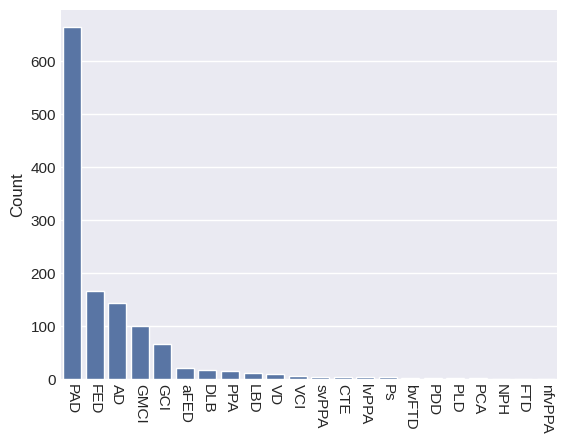

In [ ]:
fig,ax = plt.subplots(1,1)

_df = syndrome_df.group_by('code').len().sort('len',descending=True)

sns.barplot(
    _df,
    x='code',
    y='len',
    ax=ax,
)

ax.set_ylabel('Count')
ax.set_xlabel('')

ax.tick_params(axis='x', labelrotation=-90)

fig.savefig("../figures/specific_syndrome_distrib.png", bbox_inches="tight")

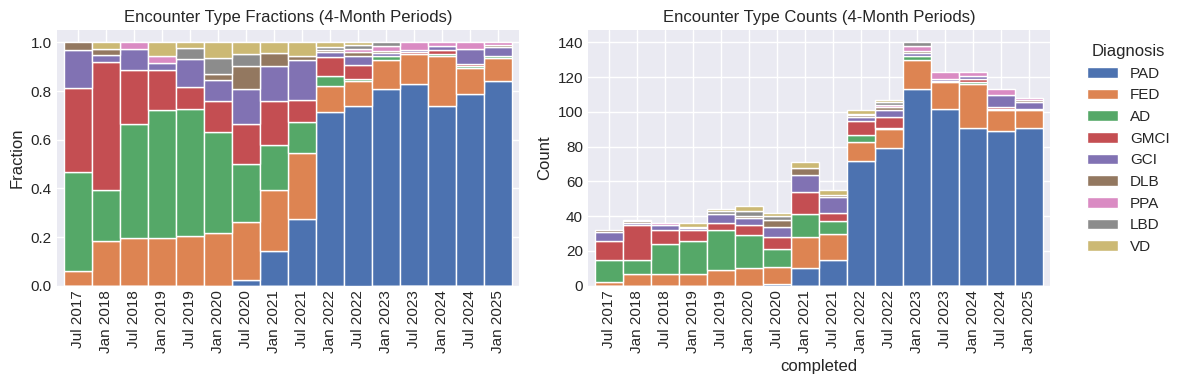

In [354]:
syndrome_order = [
    'PAD',
    'FED',
    'AD',
    'GMCI',
    'GCI',
    'DLB',
    'PPA',
    'LBD',
    'VD'
]


counts = (
    nbse_df.join(syndrome_df, on="VAC")
    .filter(pl.col('completed') >= date(2017,7,1))
    .filter(pl.col('completed') <= date(2025,6,30))
    .drop_nulls("completed")
    .drop_nulls("code")
    .with_columns(
        pl.col("completed").dt.round("6mo"),
        pl.col('code').replace({'aFED':'FED','VCI':'VD'})
    ).filter(
        pl.col('code').is_in(syndrome_order)
    )
    .group_by("completed", "code")
    .agg(pl.col("code").count().alias("count")).with_columns(
        (pl.col('count') / pl.col('count').sum().over('completed')).alias('fraction')
    ).sort('completed','code')
    .to_pandas()
)



# Bin by quarter
plt.style.use("seaborn-v0_8-darkgrid")

# Fractions
# counts["fraction"] = counts.groupby("completed")["count"].transform(
    # lambda x: x / x.sum()
# )

# Pivot for stacked bar plotting
fractions = counts.pivot(index="completed", columns="code", values="fraction").fillna(0)
counts_pivot = counts.pivot(index="completed", columns="code", values="count").fillna(0)

# Reorder columns
fractions = fractions[syndrome_order]
counts_pivot = counts_pivot[syndrome_order]

# Two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# Fractions plot
fractions.plot(kind="bar", stacked=True, ax=axes[0], width=1.0)
axes[0].set_ylabel("Fraction")
axes[0].set_title("Encounter Type Fractions (4-Month Periods)")
axes[0].set_xticklabels(
    [d.strftime("%b %Y") for d in fractions.index], rotation=90, ha="center"
)
axes[0].legend_.remove()

axes[0].set_xlabel('')
axes[1].set_xlabel('')

# Counts plot
counts_pivot.plot(kind="bar", stacked=True, ax=axes[1], width=1.0)
axes[1].set_ylabel("Count")
axes[1].set_title("Encounter Type Counts (4-Month Periods)")
axes[1].set_xticklabels(
    [d.strftime("%b %Y") for d in counts_pivot.index], rotation=90, ha="center"
)

# Legend outside
axes[1].legend(title="Diagnosis", bbox_to_anchor=(1.05, 1), loc="upper left")

fig.tight_layout()

fig.savefig('../figures/syndrome_frac_over_time.png')

Look at the distribution of the Jaccard index 
Set J below threshold to null

Cognitive diagnosis and specific clinical syndrome are separate

cog diag: Normal Cognition, Subjective Cognitive Decline, Mild Cognitive Impairment, Very Mild Dementia, Mild Dementia, Moderate Dementia, Severe Dementia.

specific syndrome/profile: Progressive Amnestic Dysfunction, Executive Dysfunction (or Frontal Executive Dysfunction or Fronto-Executive Dysfunction),

Primary Language Dysfunction (or Primary Progressive Aphasia or Semantic Dementia), Posterior Dysfunction (or Posterior Cortical Atrophy), Global Cognitive Impairment.

We may also have some cases without a descriptor above that have Frontotemporal dementia, Dementia with Lewy Bodies, Corticobasal syndrome, Parkinson’s Disease Dementia, Dementia with Lewy Bodies. There could be others, it is a bit difficult to distinguish the syndrome from the etiology in some cases. 

iterate on which onees we did not catch? a less fuzzy search may actually be better, basing it on a tokenized/TFIDF approach

In [417]:
_df = nbse_df.with_columns(pl.col('education').cut([8,12,16],labels=['Middle School', 'High School','College','Postgrad']).alias('edu_bin').cast(pl.String))

_df = _df.group_by('edu_bin').len().drop_nulls()

_df

edu_bin,len
str,u32
"""High School""",744
"""College""",834
"""Postgrad""",242
"""Middle School""",38


In [419]:
_df.with_columns(
    (pl.col('len') / pl.col('len').sum() * 100).round(2).alias('percent')
)

edu_bin,len,percent
str,u32,f64
"""High School""",744,40.04
"""College""",834,44.89
"""Postgrad""",242,13.02
"""Middle School""",38,2.05


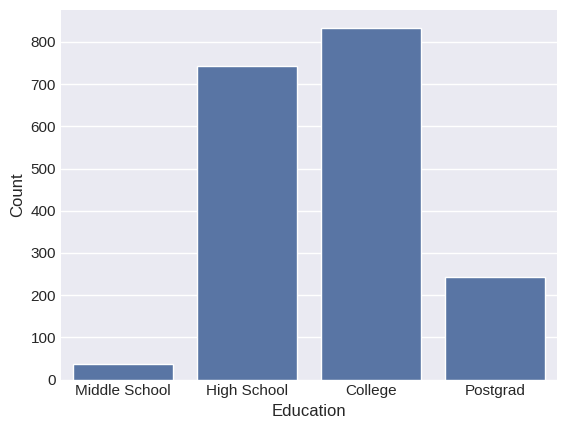

In [414]:

sns.barplot(
    _df,
    x='edu_bin',
    y='len',
    order=['Middle School','High School','College','Postgrad']
)

plt.xlabel('Education')
plt.ylabel('Count')

plt.savefig('../figures/edu_distrib.png')
